In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
%env GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json 
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json


# Adress-Merkmal Datensatz erstellen

In [3]:
query_job = client.query("SELECT * from `masterarbeit-245718.ethereum_us.top40k_week1777_features`")
start = time.time()
retrievedData = query_job.result().to_dataframe()  # Waits for job to complete.
done = time.time()
elapsed = done - start
print(elapsed)

18.125315189361572


In [4]:
results = retrievedData.copy()
results.head()

,address,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,52757990803363109075085,37972196194020000000000,14330,33393,18.109966,42.197990
1,0x5d154c145db2ca90b8ab5e8fe3e716afa4ab7ff0,5175350560981998478942,5244975800350778401905,8336,22497,26.876245,72.538452
2,0x9ae49c0d7f8f9ef4b864e004fe86ac8294e20950,19370258531717665804498,23053671968774623536152,4077,30782,19.644359,148.188911
3,0xbd6d79f3f02584cfcb754437ac6776c4c6e0a0ec,3564148762741827354478,2470600314900000000000,785,5515,109.364527,753.126276
4,0xff3c260f2391a5a936df3b693b2590045ce62d62,221741486600000000000,425797346240000000000,65,422,1432.128266,8785.468750


In [5]:
m = results.memory_usage()
totalBytes = 0

for bytes_ in m:
    totalBytes = totalBytes + bytes_
    
print("Size of the account feature dataset:",totalBytes/10**6, "Megabytes")

Size of the account feature dataset: 9.584808 Megabytes


# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [6]:
featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
featureValues = results.loc[:,featureNames]
featureValues.head()

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,52757990803363109075085,37972196194020000000000,14330,33393,18.109966,42.197990
1,5175350560981998478942,5244975800350778401905,8336,22497,26.876245,72.538452
2,19370258531717665804498,23053671968774623536152,4077,30782,19.644359,148.188911
3,3564148762741827354478,2470600314900000000000,785,5515,109.364527,753.126276
4,221741486600000000000,425797346240000000000,65,422,1432.128266,8785.468750


In [8]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
featureValuesStandardised= scaler.fit_transform(featureValues)
featureValuesStandardised = pd.DataFrame(featureValuesStandardised, columns=featureNames)
featureValuesStandardised.head()

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,21.546644,16.154493,38.485732,70.758603,-0.440679,-0.457151
1,2.092973,2.210745,22.379294,47.663649,-0.440580,-0.456809
2,7.896415,9.798311,10.934964,65.224377,-0.440661,-0.455956
3,1.434250,1.028695,2.089053,11.668924,-0.439654,-0.449140
4,0.067742,0.157487,0.154346,0.873898,-0.424803,-0.358632


# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 80% ausreicht.

In [11]:
pca2 = PCA(n_components=6)
pca2.fit(featureValuesStandardised)
pca2.explained_variance_ratio_
np.cumsum(pca2.explained_variance_ratio_)

array([0.39862491, 0.66777379, 0.81966772, 0.93250518, 0.99665139,
       1.        ])

Text(0.5, 0, 'Principal Components')

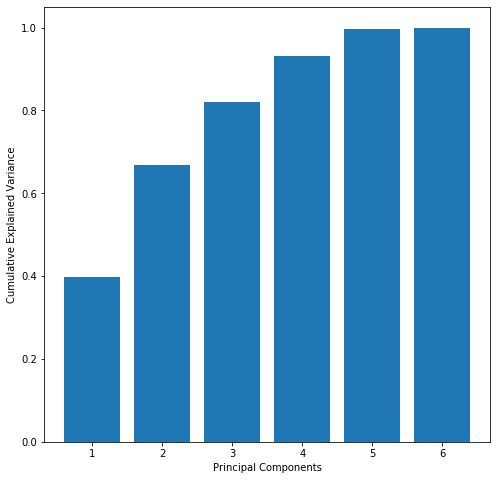

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
plt.bar([1,2,3,4,5,6], np.cumsum(pca2.explained_variance_ratio_))
ax.set_ylabel('Cumulative Explained Variance')
ax.set_xlabel('Principal Components')

In [14]:
numberOfPCAComponents = 0
explainedVarianceTargetValue = 0.8
for i in np.cumsum(pca2.explained_variance_ratio_):
    numberOfPCAComponents = numberOfPCAComponents + 1
    if i > explainedVarianceTargetValue:
        print("Die",numberOfPCAComponents,"ersten Komponenten erklären mehr als",explainedVarianceTargetValue * 100,"% der Varianz.")
        break

Die 3 ersten Komponenten erklären mehr als 80.0 % der Varianz.


In [15]:
pca = PCA(n_components=numberOfPCAComponents)
featureValuesStandardisedAndTransformed = pca.fit_transform(featureValuesStandardised)

# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

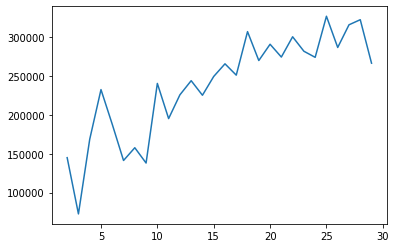

In [16]:
scores = []
numberOfCluster = []

for i in range(2,30,1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(featureValuesStandardisedAndTransformed)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans.labels_))  

plt.plot(numberOfCluster, scores)

In [17]:
print("Based on calinski_harabasz_score the number of clusters should be", numberOfCluster[np.argmax(scores)])

Based on calinski_harabasz_score the number of clusters should be 25


# Ausreißer eliminieren

In [53]:
def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
        return np.vstack(new_results), np.array(new_labels)


In [60]:
thresholds = np.linspace(.01,3, 20)
from sklearn.metrics import calinski_harabaz_score as ch_score

test = [remove_outliers(featureValuesStandardisedAndTransformed, kmeans,t) for t in thresholds]

scores= []
for (res, labels) in test:
    scores.append(metrics.calinski_harabasz_score(res, labels)) 

Text(0.5, 1.0, 'Calinski Harabaz Scores as std threshold changes')

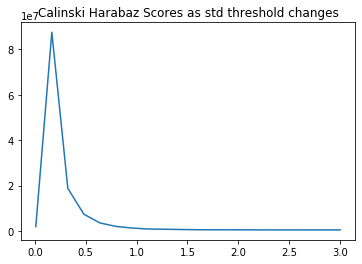

In [61]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [70]:
optimalThreshold = thresholds[np.argmax(scores)]
print("The threshold leading to the highes Calinski Harabaz Score is", optimalThreshold)


The threshold leading to the highes Calinski Harabaz Score is 0.1673684210526316


# Berechnung und Visualisierung des Entscheidungsmodells via kmeans Cluster Analyse Verfahren 

In [71]:
newresults, labels = remove_outliers(featureValuesStandardisedAndTransformed, kmeans, optimalThreshold)

In [80]:
%run ./ethereum_clustering/archive/silhouette_plotter.py
X=featureValuesStandardisedAndTransformed
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

In [74]:
#subset results for tsne
max_size = 20000
subset_results = []
lbls = []
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [75]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 53013 samples in 0.086s...
[t-SNE] Computed neighbors for 53013 samples in 3.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 53013
[t-SNE] Computed conditional probabilities for sample 2000 / 53013
[t-SNE] Computed conditional probabilities for sample 3000 / 53013
[t-SNE] Computed conditional probabilities for sample 4000 / 53013
[t-SNE] Computed conditional probabilities for sample 5000 / 53013
[t-SNE] Computed conditional probabilities for sample 6000 / 53013
[t-SNE] Computed conditional probabilities for sample 7000 / 53013
[t-SNE] Computed conditional probabilities for sample 8000 / 53013
[t-SNE] Computed conditional probabilities for sample 9000 / 53013
[t-SNE] Computed conditional probabilities for sample 10000 / 53013
[t-SNE] Computed conditional probabilities for sample 11000 / 53013
[t-SNE] Computed conditional probabilities for sample 12000 / 53013
[t-SNE] Computed conditional probabilities for sa

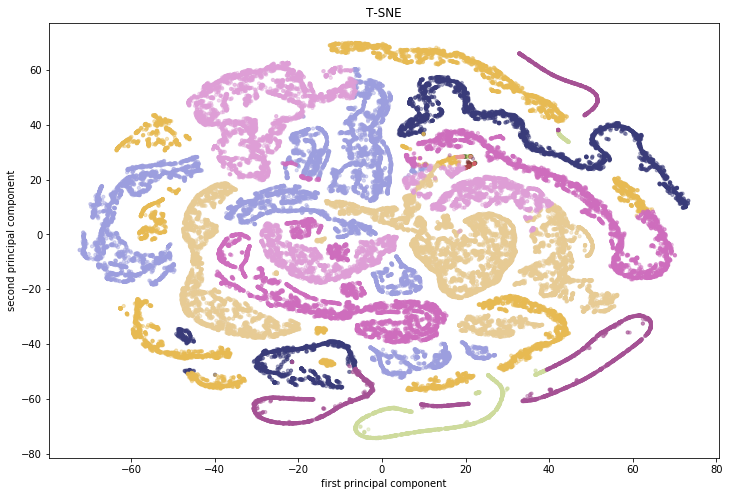

In [76]:
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Identifiziere die von den Clustern repräsentierten Nutzergruppen

# Visualisiere die Interaktion zwischen den Clustern und interpretiere die Ergebnisse

# Temporary stuff

In [ ]:
kmeans = KMeans(n_clusters=5) 
kmeans.fit(x_transformed)

In [ ]:
kmeans = KMeans(n_clusters=5) 
pca = PCA(n_components=3)
kmeans.fit(pca.fit_transform(x_transformed))

In [ ]:
pca1 = PCA(n_components=2)
principalDf = pd.DataFrame(pca1.fit_transform(x_transformed), columns=["principal component 1", "principal component 2"])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], s = 50, c=kmeans.labels_)

In [ ]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
pca3 = PCA(n_components=3)
principalDf = pd.DataFrame(pca3.fit_transform(x_transformed), columns=["principal component 1", "principal component 2", "principal component 3"])
ax.scatter3D(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], principalDf.loc[:,'principal component 3'], s = 50, c=kmeans.labels_)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

In [ ]:
ax?

In [ ]:
for i in range(0,5,1):
    res = kmeans.labels_[kmeans.labels_ == i] 
    print("Cluster {} has {} addresses.".format(i, len(res))) 


In [ ]:
results["cluster"] = kmeans.labels_
results["weiReceived"] = (results.loc[:,"weiReceived"] / 10**18).astype(float).round(2)
results["weiSent"] = (results.loc[:,"weiSent"] / 10**18).astype(float).round(2)
results.rename(columns={"weiReceived": "ethReceived", "weiSent": "ethSent"}, inplace=True)

In [ ]:
results[results.cluster == 1].describe()

In [ ]:
results[results.cluster == 0].describe()

In [ ]:
results[results.cluster == 2].describe()

In [ ]:
results[results.cluster == 3].head()

In [ ]:
results[results.cluster == 4].head()

In [ ]:
results[results.cluster == 2].head()